In [ ]:
# !pip install pandas==1.3.4
# !pip install numpy==1.21.2
# !pip install matplotlib==3.5.0
# !pip install scikit-learn==1.0.1
# !pip install hyperopt==0.2.7
# !pip install lightgbm==3.3.2

# Random Search

In [1]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, rand, hp, STATUS_OK, Trials, plotting
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [3]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [4]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [5]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [6]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [7]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [9]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [10]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [11]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define the objective function

In [12]:
def objective(space):
    estimator_clone = clone(pipe).set_params(**space)
    return {'loss': -1 * np.mean(cross_val_score(estimator_clone,
                                            X_train_full, y_train, 
                                            cv=5, scoring='f1',
                                            n_jobs=-1
                                            )
                            ), 
            'status': STATUS_OK}

Define hyperparameter space

In [13]:
hyperparameter_space = { 
"model__n_estimators": 5 + hp.randint("n_estimators", 195), 
"model__criterion": hp.choice("criterion", ["gini", "entropy"]),
"model__class_weight": hp.choice("class_weight", ["balanced","balanced_subsample"]),
"model__min_samples_split": hp.loguniform("min_samples_split", np.log(0.0001), np.log(0.5))
} 

Define the Trials object

In [14]:
trials = Trials()

Perform Random Search 

In [15]:
best = fmin(objective,
            space=hyperparameter_space,
            algo=rand.suggest,
            max_evals=100,
            rstate=np.random.default_rng(0),
            trials=trials,
           )

print(best)

100%|██████████| 100/100 [04:49<00:00,  2.89s/trial, best loss: -0.6205883932443192]
{'class_weight': 0, 'criterion': 1, 'min_samples_split': 0.00047017001935242104, 'n_estimators': 186}


Fit the pipeline on full data using the best set of hyperparameters

In [16]:
pipe = pipe.set_params(**{'model__class_weight': "balanced",
                         'model__criterion': "entropy",
                         'model__min_samples_split': 0.00047017001935242104,
                         'model__n_estimators': 186})

In [17]:
pipe.fit(X_train_full,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        min_samples_split=0.000470

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters
clf.best_params_,clf.best_score_

In [18]:
# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6237393328161365


Plot tuning process results

avg best error: -0.6205883932443192


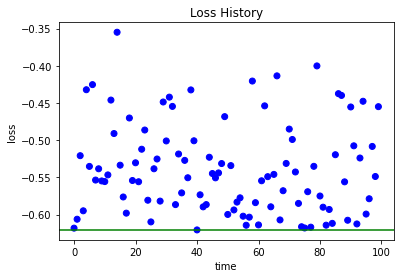

In [19]:
plotting.main_plot_history(trials)

Showing Histogram of 100 jobs


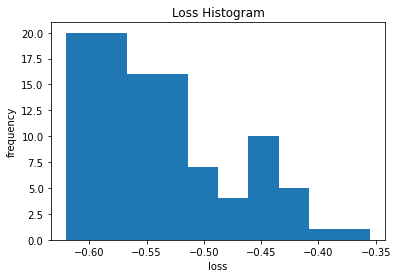

In [20]:
plotting.main_plot_histogram(trials)

finite loss range -0.6205883932443192 -0.35482020734353126 -1.6205883932443192


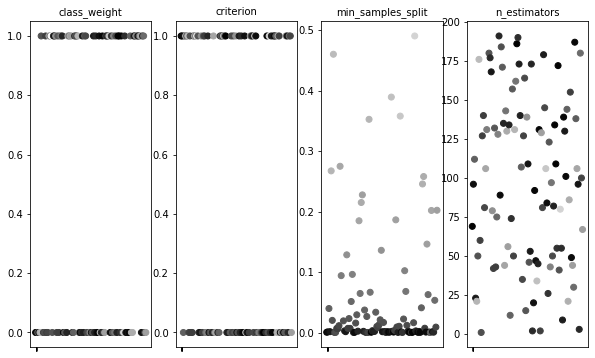

In [21]:
plt.figure(figsize=(10,6))
plotting.main_plot_vars(trials)
plt.show()

# TPE

In [22]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, plotting
import matplotlib.pyplot as plt

In [23]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [24]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [25]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [26]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [27]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [28]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [29]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [30]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [31]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [32]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define the objective function

In [33]:
def objective(space):
    estimator_clone = clone(pipe).set_params(**space)
    return {'loss': -1 * np.mean(cross_val_score(estimator_clone,
                                            X_train_full, y_train, 
                                            cv=5, scoring='f1',
                                            n_jobs=-1
                                            )
                            ), 
            'status': STATUS_OK}

Define hyperparameter space

In [34]:
hyperparameter_space = { 
"model__n_estimators": 5 + hp.randint("n_estimators", 195), 
"model__criterion": hp.choice("criterion", ["gini", "entropy"]),
"model__class_weight": hp.choice("class_weight", ["balanced","balanced_subsample"]),
"model__min_samples_split": hp.loguniform("min_samples_split", np.log(0.0001), np.log(0.5))
} 

Define the Trials object

In [35]:
trials = Trials()

Perform TPE

In [36]:
best = fmin(objective,
            space=hyperparameter_space,
            algo=tpe.suggest,
            max_evals=100,
            rstate=np.random.default_rng(0),
            trials=trials,
           )

print(best)

100%|██████████| 100/100 [05:43<00:00,  3.44s/trial, best loss: -0.6206872757696116]
{'class_weight': 1, 'criterion': 1, 'min_samples_split': 0.0005245304932726025, 'n_estimators': 138}


Fit the pipeline on full data using the best set of hyperparameters

In [37]:
pipe = pipe.set_params(**{'model__class_weight': "balanced_subsample",
                         'model__criterion': "entropy",
                         'model__min_samples_split': 0.0005245304932726025,
                         'model__n_estimators': 138})

In [38]:
pipe.fit(X_train_full,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy',
                                        min_samples_spli

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters
clf.best_params_,clf.best_score_

In [39]:
# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6212700841622035


Plot tuning process results

avg best error: -0.6206872757696116


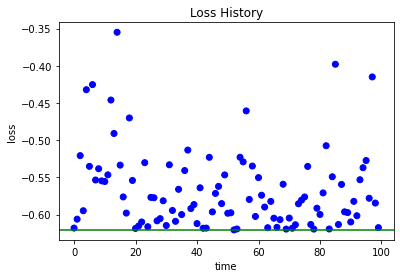

In [40]:
plotting.main_plot_history(trials)

Showing Histogram of 100 jobs


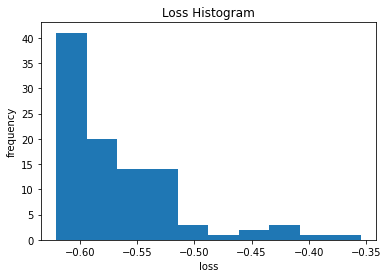

In [41]:
plotting.main_plot_histogram(trials)

finite loss range -0.6206872757696116 -0.35482020734353126 -1.6206872757696116


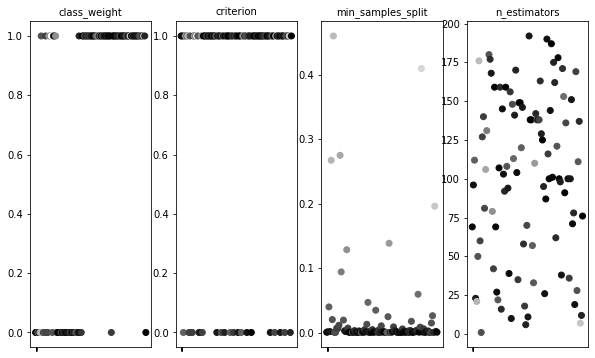

In [42]:
plt.figure(figsize=(10,6))
plotting.main_plot_vars(trials)
plt.show()

# Adaptive TPE

In [43]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, atpe, hp, STATUS_OK, Trials, plotting
import matplotlib.pyplot as plt

In [44]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [45]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [46]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [47]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [48]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [49]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [50]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [51]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [52]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [53]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define the objective function

In [54]:
def objective(space):
    estimator_clone = clone(pipe).set_params(**space)
    return {'loss': -1 * np.mean(cross_val_score(estimator_clone,
                                            X_train_full, y_train, 
                                            cv=5, scoring='f1',
                                            n_jobs=-1
                                            )
                            ), 
            'status': STATUS_OK}

Define hyperparameter space

In [55]:
hyperparameter_space = { 
"model__n_estimators": 5 + hp.randint("n_estimators", 195), 
"model__criterion": hp.choice("criterion", ["gini", "entropy"]),
"model__class_weight": hp.choice("class_weight", ["balanced","balanced_subsample"]),
"model__min_samples_split": hp.loguniform("min_samples_split", np.log(0.0001), np.log(0.5))
} 

Define the Trials object

In [56]:
trials = Trials()

Perform ATPE

In [57]:
best = fmin(objective,
            space=hyperparameter_space,
            algo=atpe.suggest,
            max_evals=100,
            rstate=np.random.default_rng(0),
            trials=trials,
           )

print(best)

100%|██████████| 100/100 [07:28<00:00,  4.48s/trial, best loss: -0.6211678386586956]
{'class_weight': 1, 'criterion': 1, 'min_samples_split': 0.0005096354197481012, 'n_estimators': 157}


Fit the pipeline on full data using the best set of hyperparameters

In [58]:
pipe = pipe.set_params(**{'model__class_weight': "balanced_subsample",
                         'model__criterion': "entropy",
                         'model__min_samples_split': 0.0005096354197481012,
                         'model__n_estimators': 157})

In [59]:
pipe.fit(X_train_full,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy',
                                        min_samples_spli

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters
clf.best_params_,clf.best_score_

In [60]:
# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6221198156682027


# Simulated Annealing

In [61]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier

from hyperopt import fmin, anneal, hp, STATUS_OK, Trials, plotting
import matplotlib.pyplot as plt

In [62]:
df = pd.read_csv("train.csv",sep=";")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Convert the target variable to integer

In [63]:
df['y'] = df['y'].map({'yes':1,'no':0})

Split full data into train and test data

In [64]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=0) 

Get list of numerical features

In [65]:
numerical_feats = list(df_train.drop(columns='y').select_dtypes(include=np.number).columns)

Get list of categorical features

In [66]:
categorical_feats = list(df_train.drop(columns='y').select_dtypes(exclude=np.number).columns)

Initiate the preprocessors

In [67]:
# Initiate the Normalization Pre-processing for Numerical Features
numeric_preprocessor = StandardScaler()

# Initiate the One-Hot-Encoding Pre-processing for Categorical Features
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")

Create the ColumnTransformer Class to delegate each preprocessor to the corresponding features

In [68]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numerical_feats),
        ("cat", categorical_preprocessor, categorical_feats),
    ]
)

Create a Pipeline of preprocessor and model

In [69]:
pipe = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("model", RandomForestClassifier(random_state=0))]
)

Get all features from the train data

In [70]:
X_train_full = df_train.drop(columns=['y'])
y_train = df_train['y']

X_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40689 entries, 17974 to 2732
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        40689 non-null  int64 
 1   job        40689 non-null  object
 2   marital    40689 non-null  object
 3   education  40689 non-null  object
 4   default    40689 non-null  object
 5   balance    40689 non-null  int64 
 6   housing    40689 non-null  object
 7   loan       40689 non-null  object
 8   contact    40689 non-null  object
 9   day        40689 non-null  int64 
 10  month      40689 non-null  object
 11  duration   40689 non-null  int64 
 12  campaign   40689 non-null  int64 
 13  pdays      40689 non-null  int64 
 14  previous   40689 non-null  int64 
 15  poutcome   40689 non-null  object
dtypes: int64(7), object(9)
memory usage: 5.3+ MB


Get all features from the test data

In [71]:
X_test_full = df_test.drop(columns=['y'])
y_test = df_test['y']

X_test_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4522 entries, 14001 to 25978
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4522 non-null   int64 
 1   job        4522 non-null   object
 2   marital    4522 non-null   object
 3   education  4522 non-null   object
 4   default    4522 non-null   object
 5   balance    4522 non-null   int64 
 6   housing    4522 non-null   object
 7   loan       4522 non-null   object
 8   contact    4522 non-null   object
 9   day        4522 non-null   int64 
 10  month      4522 non-null   object
 11  duration   4522 non-null   int64 
 12  campaign   4522 non-null   int64 
 13  pdays      4522 non-null   int64 
 14  previous   4522 non-null   int64 
 15  poutcome   4522 non-null   object
dtypes: int64(7), object(9)
memory usage: 600.6+ KB


Define the objective function

In [72]:
def objective(space):
    estimator_clone = clone(pipe).set_params(**space)
    return {'loss': -1 * np.mean(cross_val_score(estimator_clone,
                                            X_train_full, y_train, 
                                            cv=5, scoring='f1',
                                            n_jobs=-1
                                            )
                            ), 
            'status': STATUS_OK}

Define hyperparameter space

In [73]:
hyperparameter_space = { 
"model__n_estimators": 5 + hp.randint("n_estimators", 195), 
"model__criterion": hp.choice("criterion", ["gini", "entropy"]),
"model__class_weight": hp.choice("class_weight", ["balanced","balanced_subsample"]),
"model__min_samples_split": hp.loguniform("min_samples_split", np.log(0.0001), np.log(0.5))
} 

Define the Trials object

In [74]:
trials = Trials()

Perform Simulated Annealing

In [75]:
best = fmin(objective,
            space=hyperparameter_space,
            algo=anneal.suggest,
            max_evals=100,
            rstate=np.random.default_rng(0),
            trials=trials,
           )

print(best)

100%|██████████| 100/100 [08:48<00:00,  5.28s/trial, best loss: -0.6203314261900643]
{'class_weight': 1, 'criterion': 1, 'min_samples_split': 0.00046660708302994583, 'n_estimators': 189}


Fit the pipeline on full data using the best set of hyperparameters

In [76]:
pipe = pipe.set_params(**{'model__class_weight': "balanced_subsample",
                         'model__criterion': "entropy",
                         'model__min_samples_split': 0.00046660708302994583,
                         'model__n_estimators': 189})

In [77]:
pipe.fit(X_train_full,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'balance', 'day',
                                                   'duration', 'campaign',
                                                   'pdays', 'previous']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'poutcome'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        criterion='entropy',
                                        min_samples_spli

Get the f1-Score on Test Data after fitting the model on the full train data using the best set of hyperparameters
clf.best_params_,clf.best_score_

In [78]:
# Evaluate on the test data 
y_pred = pipe.predict(X_test_full)
print(f1_score(y_test, y_pred))

0.6249021143304619


Plot tuning process results

avg best error: -0.6203314261900643


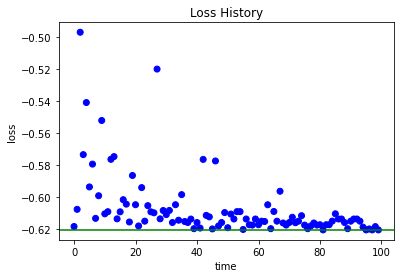

In [79]:
plotting.main_plot_history(trials)

Showing Histogram of 100 jobs


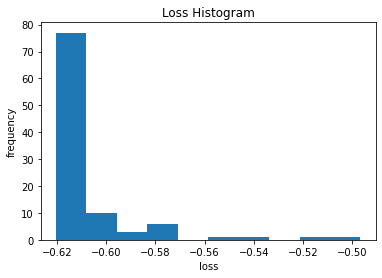

In [80]:
plotting.main_plot_histogram(trials)

finite loss range -0.6203314261900643 -0.49673714125241597 -1.6203314261900643


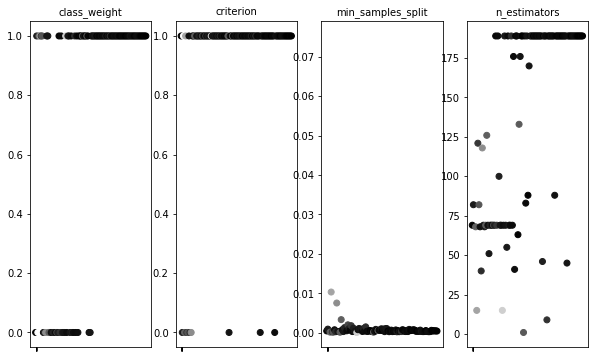

In [81]:
plt.figure(figsize=(10,6))
plotting.main_plot_vars(trials)
plt.show()

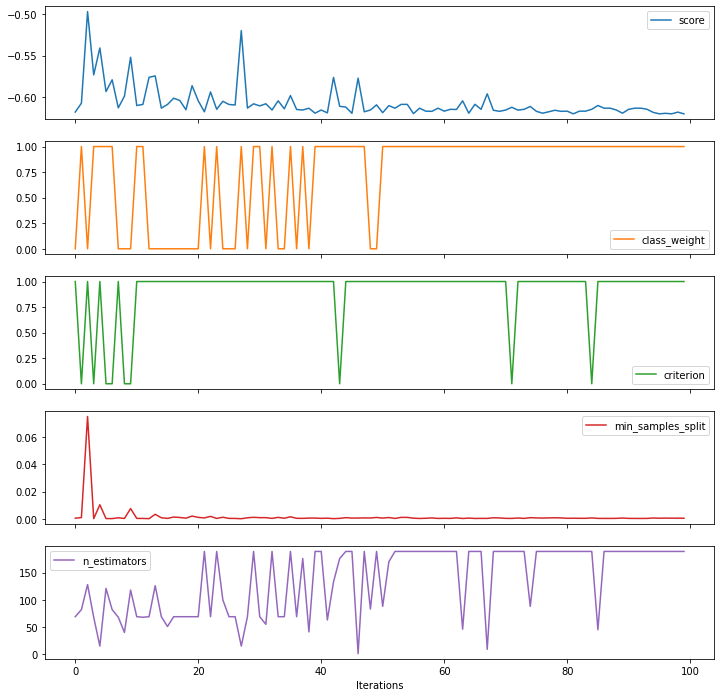

In [82]:
plotting_data = np.array([[x['result']['loss'],
                          x['misc']['vals']['class_weight'][0],
                          x['misc']['vals']['criterion'][0],
                          x['misc']['vals']['min_samples_split'][0],
                          x['misc']['vals']['n_estimators'][0],
                         ] for x in trials.trials])

plotting_data = pd.DataFrame(plotting_data,
                             columns=['score', 'class_weight', 'criterion', 'min_samples_split','n_estimators'])
plotting_data.plot(subplots=True,figsize=(12, 12))
plt.xlabel("Iterations")
plt.show()

In [83]:
plotting_data

,score,class_weight,criterion,min_samples_split,n_estimators
0,-0.618198,0.0,1.0,0.000502,69.0
1,-0.607471,1.0,0.0,0.000961,82.0
2,-0.496737,0.0,1.0,0.075230,128.0
3,-0.573251,1.0,0.0,0.000200,68.0
4,-0.540691,1.0,1.0,0.010357,15.0
...,...,...,...,...,...
95,-0.620331,1.0,1.0,0.000474,189.0
96,-0.619711,1.0,1.0,0.000567,189.0
97,-0.620331,1.0,1.0,0.000491,189.0
98,-0.618255,1.0,1.0,0.000532,189.0
